In [1]:
# ------------------------------------------define logging and working directory
from ProjectRoot import change_wd_to_project_root
change_wd_to_project_root()

from src.utils.Tensorflow_helper import choose_gpu_by_id
# ------------------------------------------define GPU id/s to use
GPU_IDS = '0,1'
GPUS = choose_gpu_by_id(GPU_IDS)
print(GPUS)

# this should import glob, os, and many other standard libs
from src.utils.Notebook_imports import *

# local imports
from src.utils.Utils_io import Console_and_file_logger, init_config
from src.visualization.Visualize import show_2D_or_3D

# import external libs
import cv2
import pandas as pd

# ------------------------------------------jupyter magic config
%matplotlib inline
%reload_ext autoreload
%autoreload 2

EXPERIMENT = 'tests/motionfull_40_128_128'
timestemp = str(datetime.datetime.now().strftime("%Y-%m-%d_%H_%M")) # ad a timestep to each project to make repeated experiments unique

EXPERIMENTS_ROOT = 'exp/'
EXP_PATH = os.path.join(EXPERIMENTS_ROOT, EXPERIMENT, timestemp)
MODEL_PATH = os.path.join(EXP_PATH, 'model', )
TENSORBOARD_PATH = os.path.join(EXP_PATH, 'tensorboard_logs')
CONFIG_PATH = os.path.join(EXP_PATH,'config')
HISTORY_PATH = os.path.join(EXP_PATH, 'history')
ensure_dir(MODEL_PATH)
ensure_dir(TENSORBOARD_PATH)
ensure_dir(CONFIG_PATH)
ensure_dir(HISTORY_PATH)

# ------------------------------------------generator hyperparameters
SEED = 42 # define a seed for the generator shuffle
BATCHSIZE = 2 # 32, 64, 24, 16, 1 for 3D use: 4
GENERATOR_WORKER = BATCHSIZE # if not set, use batchsize
DIM = [64, 128, 128] # network input params for spacing of 3, (z,y,x)
SPACING = [2, 2, 2] # if resample, resample to this spacing, (z,y,x)
DEPTH = 3 # depth of the encoder
FILTERS = 16 # initial number of filters, will be doubled after each downsampling block
M_POOL = [2, 2, 2]# size of max-pooling used for downsampling and upsampling
F_SIZE = [3, 3, 3] # conv filter size
# maybe we can drop this channel?
#IMG_CHANNELS = 1 # Currently our model needs that image channel
MASK_VALUES = [1, 2, 3]  #channel order: Background, RV, MYO, LV
MASK_CLASSES = len(MASK_VALUES) # no of labels
MASKING_IMAGE = False
MASKING_VALUES = [1,2,3]
BORDER_MODE = cv2.BORDER_REFLECT_101 # border mode for the data generation
IMG_INTERPOLATION = cv2.INTER_LINEAR # image interpolation in the genarator
MSK_INTERPOLATION = cv2.INTER_NEAREST # mask interpolation in the generator
AUGMENT = True # a compose of 2D augmentation (grid distortion, 90degree rotation, brightness and shift)
AUGMENT_PROB = 0.8
SHUFFLE = True
RESAMPLE = True
SCALER = 'Standard' # MinMax Standard or Robust

Console_and_file_logger(EXPERIMENT, logging.INFO)
config = init_config(config=locals(), save=True)
print(config)

search for root_dir and set working directory
Working directory set to: /mnt/ssd/git/dynamic-cmr-models
['/gpu:0', '/gpu:1']


2021-05-04 10:14:35,091 INFO -------------------- Start --------------------
2021-05-04 10:14:35,092 INFO Working directory: /mnt/ssd/git/dynamic-cmr-models.
2021-05-04 10:14:35,092 INFO Log file: ./logs/tests/motionfull_40_128_128.log
2021-05-04 10:14:35,092 INFO Log level for console: INFO


{'__K': None, 'GPU_IDS': '0,1', 'GPUS': ['/gpu:0', '/gpu:1'], 'SEED': 42, 'EXPERIMENT': 'tests/motionfull_40_128_128', 'EXPERIMENTS_ROOT': 'exp/', 'EXP_PATH': 'exp/tests/motionfull_40_128_128/2021-05-04_10_14', 'MODEL_PATH': 'exp/tests/motionfull_40_128_128/2021-05-04_10_14/model', 'TENSORBOARD_PATH': 'exp/tests/motionfull_40_128_128/2021-05-04_10_14/tensorboard_logs', 'CONFIG_PATH': 'exp/tests/motionfull_40_128_128/2021-05-04_10_14/config', 'HISTORY_PATH': 'exp/tests/motionfull_40_128_128/2021-05-04_10_14/history', 'BATCHSIZE': 2, 'GENERATOR_WORKER': 2, 'DIM': [64, 128, 128], 'SPACING': [2, 2, 2], 'DEPTH': 3, 'FILTERS': 16, 'M_POOL': [2, 2, 2], 'F_SIZE': [3, 3, 3], 'MASK_VALUES': [1, 2, 3], 'MASK_CLASSES': 3, 'MASKING_IMAGE': False, 'MASKING_VALUES': [1, 2, 3], 'BORDER_MODE': 4, 'IMG_INTERPOLATION': 1, 'MSK_INTERPOLATION': 0, 'AUGMENT': True, 'AUGMENT_PROB': 0.8, 'SHUFFLE': True, 'RESAMPLE': True, 'SCALER': 'Standard', 'TENSORBOARD_LOG_DIR': 'reports/tensorboard_logs/tests/motionfull_

In [2]:
######################################
# for fast tests, no choice
path_to_df = '/mnt/ssd/data/gcn/02_imported_4D_unfiltered/SAx_3D_dicomTags_phase_outcome_meta_bsa'
df = pd.read_csv(path_to_df)
df['phase'] = pd.Categorical(df.phase, 
                      categories=['ED','MS','ES','PF','MD'],
                      ordered=True)
#print(df.info())
#######################################

# load the dataframe
from ipyfilechooser import FileChooser
df_chooser = FileChooser('/mnt/ssd/data/gcn/02_imported_4D_unfiltered/')
display(df_chooser)
@interact_manual
def load_df():
    global df
    if df_chooser.selected is not None:
        path_to_df  = df_chooser.selected
        df = pd.read_csv(path_to_df)
        df['phase'] = pd.Categorical(df.phase, 
                              categories=['ED','MS','ES','PF','MD'],
                              ordered=True)
        #print(df.describe())
        print(df.info())

FileChooser(path='/mnt/ssd/data/gcn/02_imported_4D_unfiltered', filename='', title='HTML(value='', layout=Layo…

interactive(children=(Button(description='Run Interact', style=ButtonStyle()), Output()), _dom_classes=('widge…

In [3]:
# check internally if there are two columns for the patient ID, the original row from the Excel-Sheet had errors
print(df[['patient', 'PatientID']][df.PatientID != df.patient])
# extract the files for all phases
df_phases = df[['patient','x_path', 'phase']]
df_phases

      patient PatientID
5    04NEJQUZ  04NEJQU7
6    04NEJQUZ  04NEJQU7
7    04NEJQUZ  04NEJQU7
8    04NEJQUZ  04NEJQU7
9    04NEJQUZ  04NEJQU7
640  GZH20326  6ZH20326
641  GZH20326  6ZH20326
642  GZH20326  6ZH20326
643  GZH20326  6ZH20326
644  GZH20326  6ZH20326
890  PEXM9GEK  PEXM9GE 
891  PEXM9GEK  PEXM9GE 
892  PEXM9GEK  PEXM9GE 
893  PEXM9GEK  PEXM9GE 
894  PEXM9GEK  PEXM9GE 


,patient,x_path,phase
0,02Z1L14N,/mnt/ssd/data/gcn/02_imported_4D_unfiltered/SA...,MS
1,02Z1L14N,/mnt/ssd/data/gcn/02_imported_4D_unfiltered/SA...,ES
2,02Z1L14N,/mnt/ssd/data/gcn/02_imported_4D_unfiltered/SA...,PF
3,02Z1L14N,/mnt/ssd/data/gcn/02_imported_4D_unfiltered/SA...,MD
4,02Z1L14N,/mnt/ssd/data/gcn/02_imported_4D_unfiltered/SA...,ED
...,...,...,...
1320,ZZQ0001Q,/mnt/ssd/data/gcn/02_imported_4D_unfiltered/SA...,ED
1321,ZZQ0001Q,/mnt/ssd/data/gcn/02_imported_4D_unfiltered/SA...,MS
1322,ZZQ0001Q,/mnt/ssd/data/gcn/02_imported_4D_unfiltered/SA...,ES
1323,ZZQ0001Q,/mnt/ssd/data/gcn/02_imported_4D_unfiltered/SA...,PF


In [4]:
# zip the phase files in the following structure:
#[[patient1_phase1, patient1_phase2, patient1_phase3, patient1_phase4, patient1_phase5],[patient2_phase1...] ...]

ed = df_phases[df_phases['phase'] == 'ED']['x_path']
ms = df_phases[df_phases['phase'] == 'MS']['x_path']
es = df_phases[df_phases['phase'] == 'ES']['x_path']
pf = df_phases[df_phases['phase'] == 'PF']['x_path']
md = df_phases[df_phases['phase'] == 'MD']['x_path']

# zip the phase list into one list of lists/tuples
input_files = list(zip(ed,ms,es,pf,md))
output_files = list(zip(ms,es,pf,md,ed))

In [5]:
# initialise a generator with these files
# logging.getLogger().setLevel(logging.INFO)
from src.data.Generators import MotionDataGenerator
config['AUGMENT'] = True
config['RESAMPLE'] = True
batch_generator = MotionDataGenerator(input_files, output_files, config=config)
val_config = config.copy()
val_config['AUGMENT'] = False
validation_generator = MotionDataGenerator(input_files, output_files , config=val_config)

2021-05-04 10:14:37,218 INFO Create DataGenerator
2021-05-04 10:14:37,223 INFO Datagenerator created with: 
 shape: [64, 128, 128]
 spacing: [2, 2, 2]
 batchsize: 2
 Scaler: Standard
 Images: 265 
 Augment: True 
 Thread workers: 2
2021-05-04 10:14:37,224 INFO Data will be augmented (shift,scale and rotate) with albumentation
2021-05-04 10:14:37,224 INFO Create DataGenerator
2021-05-04 10:14:37,229 INFO Datagenerator created with: 
 shape: [64, 128, 128]
 spacing: [2, 2, 2]
 batchsize: 2
 Scaler: Standard
 Images: 265 
 Augment: False 
 Thread workers: 2
2021-05-04 10:14:37,230 INFO No augmentation


In [6]:
# visualise one batch
@interact_manual
def select_image_in_batch(batch = (0,len(batch_generator), 1), im = (0,BATCHSIZE- 1, 1), slice_n=(1,11), save=False, filepath='data/temp/', filename='temp_x.npy'):
    
    import time
    global inputs, outputs
    t1 = time.time()
    inputs, outputs = batch_generator.__getitem__(batch)
    if type(inputs)==list:inputs, outputs = inputs[0], outputs[0]
    logging.info('Preprocessing took: {:0.3f}'.format(time.time() - t1))
    print(inputs.shape, outputs.shape)
    print('selected batch : ' + str(batch))
    
    selected_input = inputs[im]
    selected_output = outputs[im]
    
    list(map(lambda x: show_2D_or_3D(img=x[::slice_n], interpol='bilinear',dpi=100,f_size=(5,5)), selected_input))
    plt.show()
    info('-'*100)
    list(map(lambda y: show_2D_or_3D(img=y[::slice_n], interpol='bilinear',dpi=100,f_size=(5,5)), selected_output))
    plt.show()
    """
        show_2D_or_3D(x[im], y[im], interpol='bilinear',dpi=100,f_size=(5,5))
    plt.show()
    """
    plt.hist(selected_input.flatten(), bins=np.linspace(0.1,1,20))
    plt.show()
    if save:
        ensure_dir(filepath)
        np.save(os.path.join(filepath, filename), x[im])
        logging.info('saved to {}'.format(os.path.join(filepath, filename)))
    



interactive(children=(IntSlider(value=66, description='batch', max=132), IntSlider(value=0, description='im', …

2021-05-04 10:14:48,146 INFO plot_3d_vol sliced first axis 64 by 3


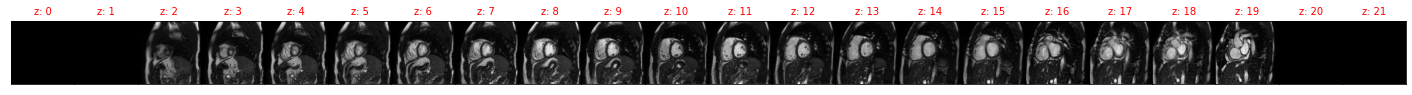

2021-05-04 10:14:48,610 INFO plot_3d_vol sliced first axis 64 by 3


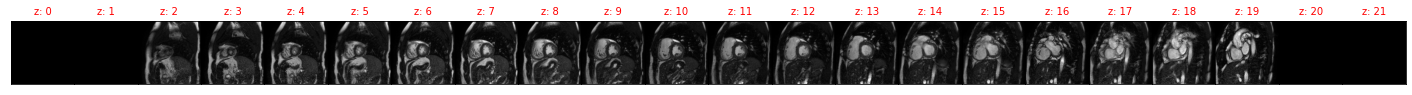

2021-05-04 10:14:49,075 INFO plot_3d_vol sliced first axis 64 by 3


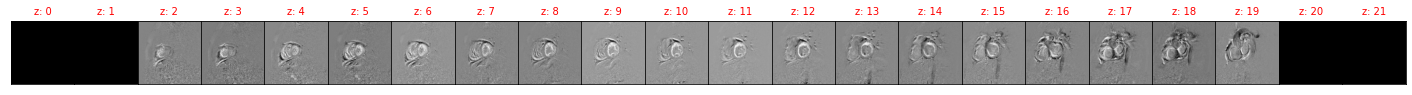

In [7]:
# anual check if inputs and outputs match
show_2D_or_3D(inputs[0][0]);plt.show()
show_2D_or_3D(outputs[0][0]);plt.show()
show_2D_or_3D(inputs[0][0]- outputs[0][0]);plt.show()

In [8]:
from src.models.Models import create_RegistrationModel

import tensorflow

if tensorflow.distribute.has_strategy():
    strategy = tensorflow.distribute.get_strategy()
else:
    # distribute the training with the "mirrored data"-paradigm across multiple gpus if available, if not use gpu 0
    strategy = tensorflow.distribute.MirroredStrategy(devices=config.get('GPUS', ["/gpu:0"]))
with strategy.scope():
    model = create_RegistrationModel(config=config)

using tensorflow, need to monkey patch
tf.python.backend.slice overwritten by monkey patch
INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1')


2021-05-04 10:14:50,465 INFO Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1')


(None, 64, 128, 128, 1)
(None, 64, 128, 128, 1)
Instructions for updating:
Use fn_output_signature instead


2021-05-04 10:14:51,574 WARNING From /home/sven/anaconda3/envs/dcmr/lib/python3.8/site-packages/tensorflow/python/util/deprecation.py:574: calling map_fn_v2 (from tensorflow.python.ops.map_fn) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Use fn_output_signature instead


In [9]:
model.summary()

Model: "simpleregister"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 5, 64, 128,  0                                            
__________________________________________________________________________________________________
tf_op_layer_unstack (TensorFlow [(None, 64, 128, 128 0           input_1[0][0]                    
__________________________________________________________________________________________________
unet (Functional)               (None, 64, 128, 128, 1604832     tf_op_layer_unstack[0][1]        
                                                                 tf_op_layer_unstack[0][2]        
                                                                 tf_op_layer_unstack[0][4]        
                                                                 tf_op_layer_unstack[

In [10]:
import tensorflow
from tensorflow.keras.losses import mse
from src.utils.Metrics import Grad, MSE_
if 'strategy' in locals():
    pass
else:
    # distribute the training with the "mirrored data"-paradigm across multiple gpus if available, if not use gpu 0
    strategy = tensorflow.distribute.MirroredStrategy(devices=config.get('GPUS', ["/gpu:0"]))
with strategy.scope():

    losses = [mse, Grad('l1').loss]
    weights = [1,0.01]
    model.compile(optimizer=tensorflow.keras.optimizers.Adam(), loss=losses, loss_weights=weights)

In [11]:
from src.utils.KerasCallbacks import get_callbacks

results = model.fit(
    x=batch_generator,
    validation_data=validation_generator,
    epochs=100,
    callbacks = get_callbacks(config, batch_generator,validation_generator),
    initial_epoch=0,
    max_queue_size=12,
    use_multiprocessing=False,
    verbose=1)

Epoch 1/100
Instructions for updating:
Use `tf.data.Iterator.get_next_as_optional()` instead.


2021-05-04 10:14:53,716 WARNING From /home/sven/anaconda3/envs/dcmr/lib/python3.8/site-packages/tensorflow/python/data/ops/multi_device_iterator_ops.py:601: get_next_as_optional (from tensorflow.python.data.ops.iterator_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use `tf.data.Iterator.get_next_as_optional()` instead.


INFO:tensorflow:batch_all_reduce: 36 all-reduces with algorithm = nccl, num_packs = 1


2021-05-04 10:15:00,905 INFO batch_all_reduce: 36 all-reduces with algorithm = nccl, num_packs = 1


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


2021-05-04 10:15:01,213 INFO Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


2021-05-04 10:15:01,215 INFO Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


2021-05-04 10:15:01,218 INFO Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


2021-05-04 10:15:01,221 INFO Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


2021-05-04 10:15:01,224 INFO Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


2021-05-04 10:15:01,226 INFO Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:batch_all_reduce: 36 all-reduces with algorithm = nccl, num_packs = 1


2021-05-04 10:15:09,006 INFO batch_all_reduce: 36 all-reduces with algorithm = nccl, num_packs = 1


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


2021-05-04 10:15:09,220 INFO Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


2021-05-04 10:15:09,222 INFO Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


2021-05-04 10:15:09,226 INFO Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


2021-05-04 10:15:09,228 INFO Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


132/132 [==============================] - ETA: 0s - loss: 0.0910 - tf_op_layer_stack_loss: 0.0908 - tf_op_layer_stack_1_loss: 0.0294
Epoch 00001: loss improved from inf to 0.09105, saving model to exp/tests/motionfull_40_128_128/2021-05-04_10_14/model/model.h5
132/132 [==============================] - 262s 2s/step - loss: 0.0910 - tf_op_layer_stack_loss: 0.0908 - tf_op_layer_stack_1_loss: 0.0294 - val_loss: 0.0904 - val_tf_op_layer_stack_loss: 0.0903 - val_tf_op_layer_stack_1_loss: 0.0103 - lr: 0.0010
Epoch 2/100
132/132 [==============================] - ETA: 0s - loss: 0.0892 - tf_op_layer_stack_loss: 0.0889 - tf_op_layer_stack_1_loss: 0.0237
Epoch 00002: loss improved from 0.09105 to 0.08918, saving model to exp/tests/motionfull_40_128_128/2021-05-04_10_14/model/model.h5
132/132 [==============================] - 278s 2s/step - loss: 0.0892 - tf_op_layer_stack_loss: 0.0889 - tf_op_layer_stack_1_loss: 0.0237 - val_loss: 0.0934 - val_tf_op_layer_stack_loss: 0.0932 - val_tf_op_layer_

In [12]:
inputs.shape

(2, 5, 64, 128, 128, 1)

In [13]:
pred = model.predict(x=inputs)

In [14]:
transformed, flow = pred
print(transformed.shape)
print(flow.shape)

(2, 5, 64, 128, 128, 1)
(2, 5, 64, 128, 128, 3)


In [26]:
np.save('reports/flow.npz',flow)
np.save('reports/input.npz',inputs)
np.save('reports/target.npz',outputs)

# Save one 3D volume

In [15]:
export_path = 'reports/exampleflows'
experiment_ = '{}/fullimage128_32'.format(export_path)
ensure_dir(experiment_)
flowname = os.path.join(experiment_, '_flow.nii')
firstfilename = os.path.join(experiment_, '_cmr.nii')
secondfilename = os.path.join(experiment_, '_targetcmr.nii')
t = 3

In [15]:
def save_3d(nda, fname):
    # save one flowfield
    sitk_img = sitk.GetImageFromArray(nda, isVector=False)
    sitk.WriteImage(sitk_img, fname)

def save_all_3d_vols(inputs, outputs, flow, export_path='reports/exampleflows', exp='fullimage128_32_temp'):
    experiment_ = '{}/{}'.format(export_path, exp)
    info(experiment_)
    ensure_dir(experiment_)
    flowname = os.path.join(experiment_, '_flow.nii')
    firstfilename = os.path.join(experiment_, '_cmr.nii')
    secondfilename = os.path.join(experiment_, '_targetcmr.nii')
    
    # invert the axis
    flow = np.einsum('tzyxc->cxyzt', flow)
    inputs = np.einsum('tzyxc->cxyzt', inputs)
    outputs = np.einsum('tzyxc->cxyzt', outputs)
    
    _ = [save_3d(flow[...,t], flowname.replace('.nii', '_{}_.nii'.format(t))) for t in range(flow.shape[-1])]
    _ = [save_3d(inputs[...,t], firstfilename.replace('.nii', '_{}_.nii'.format(t))) for t in range(inputs.shape[-1])]
    _ = [save_3d(outputs[...,t], secondfilename.replace('.nii', '_{}_.nii'.format(t))) for t in range(outputs.shape[-1])]
    
    _ = [save_3d(flow[...,t,:], flowname.replace('.nii', '_sequence_{}_.nii'.format(t))) for t in range(flow.shape[-2])]
    _ = [save_3d(inputs[...,t,:], firstfilename.replace('.nii', '_sequence_{}_.nii'.format(t))) for t in range(inputs.shape[-2])]
    _ = [save_3d(outputs[...,t,:], secondfilename.replace('.nii', '_sequence_{}_.nii'.format(t))) for t in range(outputs.shape[-2])]
    
save_all_3d_vols(inputs[0], outputs[0], flow[0], exp='full_64_128_128')

2021-05-04 18:32:00,417 INFO reports/exampleflows/full_64_128_128


In [16]:
# save one flowfield
flow_single = flow[0]
print(flow_single.shape)
flow_single = np.einsum('tzyxc->cxyzt', flow_single)
flow_single = flow_single[...,t]
flow_sitk = sitk.GetImageFromArray(flow_single, isVector=False)
print(flow_sitk.GetSize())
sitk.WriteImage(flow_sitk, flowname)

(5, 32, 128, 128, 3)
(32, 128, 128, 3)


In [17]:
# save the first time step
inputs_single = inputs[0]
print(inputs_single.shape)
inputs_single = np.einsum('tzyxc->cxyzt', inputs_single)
inputs_single = inputs_single[...,t]
input_sitk = sitk.GetImageFromArray(inputs_single, isVector=False)
print(input_sitk.GetSize())
sitk.WriteImage(input_sitk, firstfilename)

(5, 32, 128, 128, 1)
(32, 128, 128, 1)


In [18]:
# save the second time step
outputs_single = outputs[0]
print(outputs_single.shape)
outputs_single = np.einsum('tzyxc->cxyzt', outputs_single)
outputs_single = outputs_single[...,t]
output_sitk = sitk.GetImageFromArray(outputs_single, isVector=False)
print(output_sitk.GetSize())
sitk.WriteImage(output_sitk, secondfilename)

(5, 32, 128, 128, 1)
(32, 128, 128, 1)


# save one 2D+T volume

In [31]:
temporalflowname = flowname.replace('flow.nii', 'tempflow.nii')
temporalfirstfilename = firstfilename.replace('cmr.nii', 'tempcmr.nii')
temporalsecondfilename = secondfilename.replace('targetcmr.nii', 'temptargetcmr.nii')
slice_ = 15

In [32]:
# save one 2D+t flowfield
flow_single = flow[0]
print(flow_single.shape)
flow_single = np.einsum('tzyxc->cxyzt', flow_single)
print(flow_single.shape)
flow_single = flow_single[:,:,:,slice_,:]
print(flow_single.shape)
flow_sitk = sitk.GetImageFromArray(flow_single, isVector=False)
print(flow_sitk.GetSize())
print(flow_sitk.GetNumberOfComponentsPerPixel())
sitk.WriteImage(flow_sitk, temporalflowname)

(5, 32, 128, 128, 3)
(3, 128, 128, 32, 5)
(3, 128, 128, 5)
(5, 128, 128, 3)
1


In [33]:
# save the first time step
inputs_single = inputs[0]
print(inputs_single.shape)
inputs_single = np.einsum('tzyxc->cxyzt', inputs_single)
print(inputs_single.shape)
inputs_single = inputs_single[:,:,:,slice_,:]
print(inputs_single.shape)
input_sitk = sitk.GetImageFromArray(inputs_single, isVector=False)
print(input_sitk.GetSize())
sitk.WriteImage(input_sitk, temporalfirstfilename)

(5, 32, 128, 128, 1)
(1, 128, 128, 32, 5)
(1, 128, 128, 5)
(5, 128, 128, 1)


In [34]:
# save the 2nd time step
outputs_single = outputs[0]
print(outputs_single.shape)
outputs_single = np.einsum('tzyxc->cxyzt', outputs_single)
print(outputs_single.shape)
outputs_single = outputs_single[:,:,:,slice_,:]
print(outputs_single.shape)
output_sitk = sitk.GetImageFromArray(outputs_single, isVector=False)
print(output_sitk.GetSize())
sitk.WriteImage(output_sitk, temporalsecondfilename)

(5, 32, 128, 128, 1)
(1, 128, 128, 32, 5)
(1, 128, 128, 5)
(5, 128, 128, 1)


# save 4D flow

In [130]:
# save the second time step
temp = flow[0]
print(temp.shape)
#temp = np.einsum('tzyxc->ctzyx', temp)
#temp = [temp[:,:,:,i,:] for i in range(outputs_single.shape[-2])]
temp = sitk.JoinSeries([sitk.GetImageFromArray(img, isVector=False) for img in temp])
print(temp.GetSize())
print(temp.GetNumberOfComponentsPerPixel())
sitk.WriteImage(temp, os.path.join(experiment_, '4dflow.nii'))

(5, 30, 128, 128, 3)
(3, 128, 128, 30, 5)
1


In [138]:
# stack two slices - tests
flow_single = flow[0]
print(flow_single.shape)
flow_single = flow_single[:,slice_,:,:,:]
print(flow_single.shape)
flow_single = np.einsum('tyxc->cxyt', flow_single)
print(flow_single.shape)
flow_single = np.concatenate([flow_single,flow_single], axis=-1)
print(flow_single.shape)
flow_sitk = sitk.GetImageFromArray(flow_single, isVector=True)
print(flow_sitk.GetSize())
print(flow_sitk.GetNumberOfComponentsPerPixel())
sitk.WriteImage(flow_sitk, temporalflowname)

(5, 30, 128, 128, 3)
(5, 128, 128, 3)
(3, 128, 128, 5)
(3, 128, 128, 10)
(128, 128, 3)
10


In [151]:
# stack z x 2D+T flows - works
flow_single = flow[0]
print(flow_single.shape)
flows = np.split(flow_single,indices_or_sections=flow_single.shape[1], axis=1)
print(flows[0].shape)
flows = [np.einsum('tyxc->cxyt', np.squeeze(f)) for f in flows]
print(flows[0].shape)
flows = np.concatenate(flows, axis=-1)
print(flows.shape)
flow_sitk = sitk.GetImageFromArray(flows, isVector=False)
print(flow_sitk.GetSize())
print(flow_sitk.GetNumberOfComponentsPerPixel())
sitk.WriteImage(flow_sitk, experiment_+'/stacked_2d+t.nii')

(5, 30, 128, 128, 3)
(5, 1, 128, 128, 3)
(3, 128, 128, 5)
(3, 128, 128, 150)
(150, 128, 128, 3)
1


In [162]:
# stack z x 2D+T slices - tests
flow_single = np.squeeze(inputs[0])
print(flow_single.shape)
flow_single = np.reshape(flow_single,(150,128,128))
flow_sitk = sitk.GetImageFromArray(flow_single, isVector=False)
print(flow_sitk.GetSize())
print(flow_sitk.GetNumberOfComponentsPerPixel())
sitk.WriteImage(flow_sitk, experiment_+'/stacked_1st_cmr.nii')

(5, 30, 128, 128)
(128, 128, 150)
1


In [78]:
# save one 2D+t flowfield
flow_single = flow[0]
flow_single = np.einsum('tzyxc->cxyzt', flow_single)
flows = np.split(flow_single, indices_or_sections=5, axis=-1)
flows = [sitk.DisplacementFieldTransform(f) for f in flows]
flow_sitk = sitk.JoinSeries(flows)
print(flow_sitk.GetSize())
sitk.WriteTransform(flow_sitk, 'reports/examplefullflow_4d.nrrd')

TypeError: Wrong number or type of arguments for overloaded function 'new_DisplacementFieldTransform'.
  Possible C/C++ prototypes are:
    itk::simple::DisplacementFieldTransform::DisplacementFieldTransform(unsigned int)
    itk::simple::DisplacementFieldTransform::DisplacementFieldTransform(itk::simple::Image &)
    itk::simple::DisplacementFieldTransform::DisplacementFieldTransform(itk::simple::DisplacementFieldTransform const &)
    itk::simple::DisplacementFieldTransform::DisplacementFieldTransform(itk::simple::Transform const &)


In [164]:
# save one flowfield
flow_single = flow[0]
print(flow_single.shape)
#flow_single = np.einsum('tzyxc->ctzyx', flow_single)
print(flow_single.shape)
#flow_single = flow_single[...,t]

#flow_single = np.reshape(flow_single, newshape=(15,30,128,128), order='F')
print(flow_single.shape)
flow_sitk = sitk.GetImageFromArray(flow_single, isVector=False)
print(flow_sitk.GetSize())
sitk.WriteImage(flow_sitk, flowname)

(5, 30, 128, 128, 3)
(5, 30, 128, 128, 3)
(5, 30, 128, 128, 3)
(3, 128, 128, 30, 5)


In [ ]:
flow_sitk = sitk.GetImageFromArray(flow[0], isVector=False)
sitk.WriteImage(flow_sitk, 'reports/example2flow.ni.gz')

"""inputs_sitk = sitk.GetImageFromArray(inputs)
outputs_sitk = sitk.GetImageFromArray(outputs)"""

In [16]:
from src.visualization.Visualize import create_quiver_plot

@interact
def show_pred(t=(0,5), slice_z=(0,5), debug_=False):
    info('input')
    if debug_:list(map(lambda x: show_2D_or_3D(img=x[::slice_z], interpol='bilinear',dpi=100,f_size=(5,5)), inputs[0][t:t+1]));plt.show()
    info('target')
    if debug_:list(map(lambda x: show_2D_or_3D(img=x[::slice_z], interpol='bilinear',dpi=100,f_size=(5,5)), outputs[0][t:t+1]));plt.show()
    diff = inputs - outputs
    info('diff input')
    if debug_:list(map(lambda x: show_2D_or_3D(img=x[::slice_z], interpol='bilinear',dpi=100,f_size=(5,5)), diff[0][t:t+1]));plt.show()
    info('pred')
    if debug_:list(map(lambda x: show_2D_or_3D(img=x[::slice_z], interpol='bilinear',dpi=100,f_size=(5,5)), transformed[0][t:t+1]));plt.show()
    info('diff pred')
    diff = transformed - outputs
    if debug_:list(map(lambda x: show_2D_or_3D(img=x[::slice_z], interpol='bilinear',dpi=100,f_size=(5,5)), diff[0][t:t+1]));plt.show()
    if debug_:fig,axes = plt.subplots(1,flow.shape[2]//slice_z, figsize=(24,2))
    if debug_:list(map(lambda x: create_quiver_plot(flowfield_2d=x[1],indexing='ij', scale=0.5, N=1,ax=x[0]), zip(axes,flow[0][t][::slice_z]))); plt.show() # third timestep
    list(map(lambda x: show_2D_or_3D(mask=x[::slice_z], interpol='bilinear',dpi=100,f_size=(5,5)) and plt.show(), flow[0][t:t+1]))
    plt.show()
    if debug_:plt.hist(flow[0].flatten())

interactive(children=(IntSlider(value=2, description='t', max=5), IntSlider(value=2, description='slice_z', ma…